# [Is Russia Stock a Good Hedge for Ruble?] 
In this notebook, I hope to show how a empirical risk manager would go about working through a problem. The goal is to figure out if the Russia stock could provide hedging for holding Ruble, given a scenario that investors could liquidate their long positions in stock then get Ruble back, but cannot liquidate the Ruble to get USD back.  

The second step is to come up an optimal asset allocation (in term of a specified portfolio objective function) given the RUBUSD and a set of stock indices or a basket of single-name securities. Then I will add some metric calculation to evaluate the holding weight and allocation performance out-of-sample.  

Finally, if time allows, I will do some comparison analysis between the LO and LS portfolios given the potential existence of a long-only constraint, either in active or absolute space. There are several impact factors under consideration: (1) market dispersion / underlying corr, (2) (active) risk budget, (3) size of underlying universe. Resulted metrics may include: (1) transfer coef. (2) security-level risk concentration level, (3) proportion of incidential (active) risk taking on styles.  


## Overview 
### 1) Data Cleaning, Understand the data and corr

### 2) Time varing beta estimate for stock indices (against RUBUSD)

### 3) TBD

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

import scipy.stats as ss
from scipy.linalg import inv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#drive.flush_and_unmount()

# 1) Data Cleaning, Understand the data and corr

In [4]:
sheet_to_df_map = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AllData_0527.xlsx', sheet_name=None)

In [5]:
sheet_to_df_map.keys()

dict_keys(['MXRU', 'MXRUIM', 'MXRUOCS', 'MGUERUS', 'MXRUOMT', 'MXRU0EN', 'MXRU0TC', 'MXRU0UT', 'MXRU0FN', 'MVUERUS', 'MXRULC', 'MXRUMC', 'MXRUSC', 'RUBUSD Spot'])

In [6]:
len(sheet_to_df_map.keys())

14

In [7]:
Prc_df = sheet_to_df_map['MXRU'][['Date','Last Price']]

In [8]:
Prc_df.rename(columns = {'Last Price':'MXRU'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
cur_cnt = 0
for key, value in sheet_to_df_map.items():
  if cur_cnt == 0:
    cur_cnt += 1
    pass
  else:
    Prc_df = pd.merge(Prc_df, value[['Date','Last Price']], on='Date', how='outer')
    Prc_df.rename(columns = {'Last Price':key}, inplace = True)

In [10]:
Prc_df = Prc_df.loc[Prc_df['Date'] <= pd.Timestamp(2022,3,7,0)]

In [11]:
Prc_df.sort_values('Date', inplace=True)

In [12]:
Ret_df = Prc_df.copy(deep=True)

In [13]:
Ret_df[list(sheet_to_df_map.keys())] = Prc_df[list(sheet_to_df_map.keys())].pct_change().fillna(0.0)

In [14]:
Ret_df.set_index('Date', inplace=True)

In [15]:
CumRet_df = (1+Ret_df).cumprod()

Overall Mkt Index vs FX

Text(0.5, 1.0, 'Overall Mkt index vs RUBUSD')

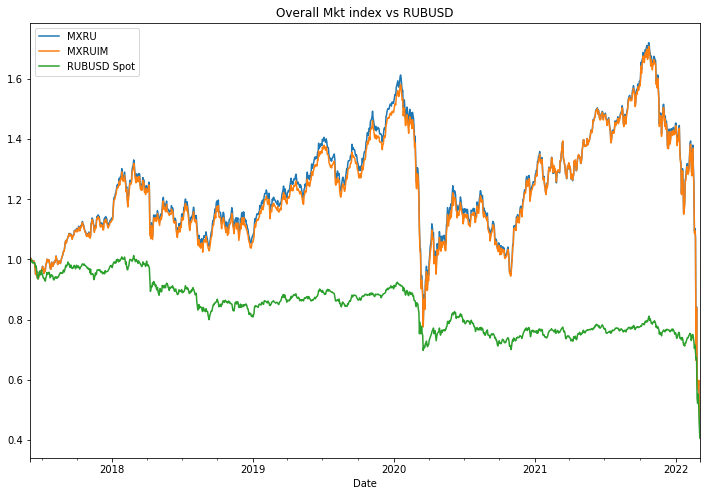

In [17]:
CumRet_df[['MXRU','MXRUIM','RUBUSD Spot']].plot(figsize=(12,8))
plt.legend(loc='best')
plt.title('Overall Mkt index vs RUBUSD')

Large/Mid/Small Caps vs FX

Text(0.5, 1.0, 'Mkt Cap index vs RUBUSD')

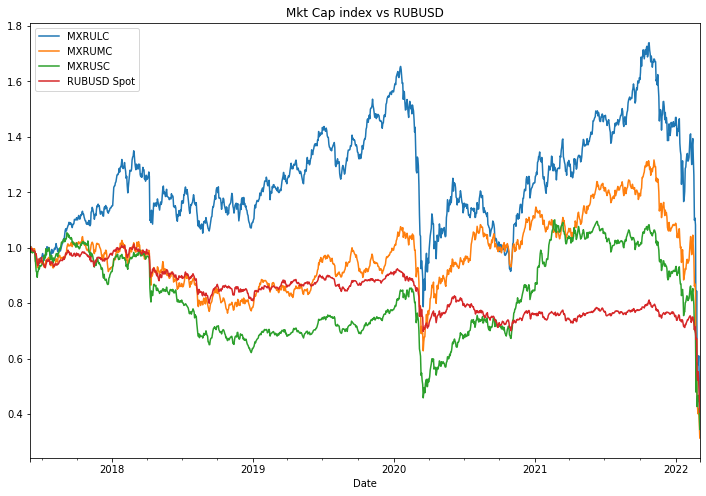

In [18]:
CumRet_df[['MXRULC','MXRUMC','MXRUSC','RUBUSD Spot']].plot(figsize=(12,8))
plt.legend(loc='best')
plt.title('Mkt Cap index vs RUBUSD')

Styles vs FX

Text(0.5, 1.0, 'Growth/Value index vs RUBUSD')

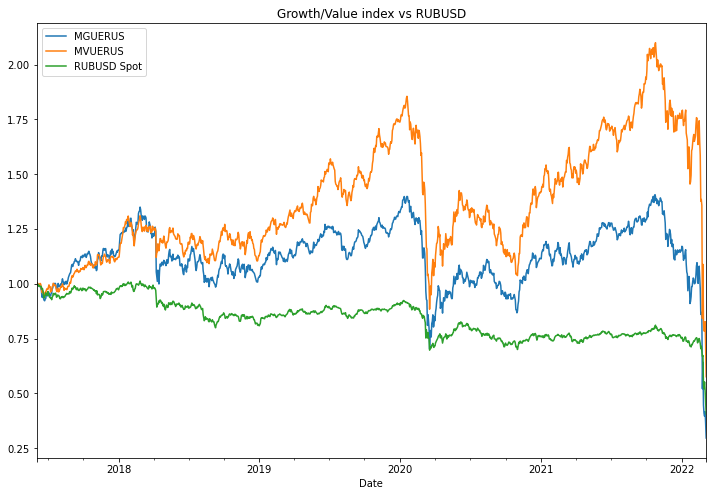

In [19]:
CumRet_df[['MGUERUS','MVUERUS','RUBUSD Spot']].plot(figsize=(12,8))
plt.legend(loc='best')
plt.title('Growth/Value index vs RUBUSD')

Sector Indices vs FX

Text(0.5, 1.0, 'ConsumerStaple/Material/Energy/CommunicationService/Utility/Financial index vs RUBUSD')

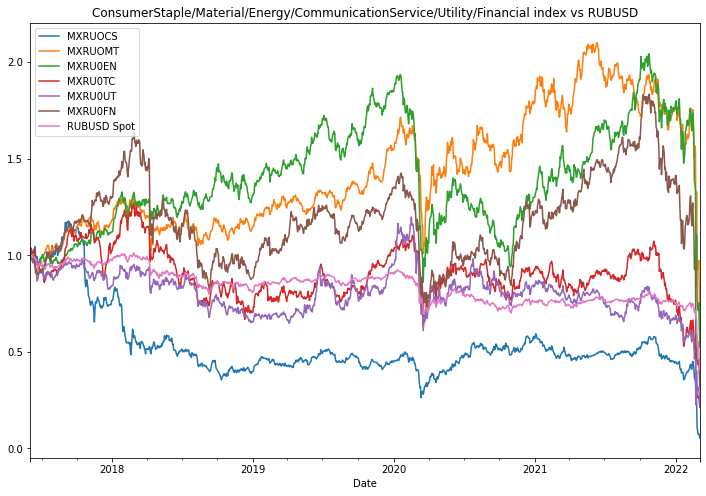

In [20]:
CumRet_df[['MXRUOCS','MXRUOMT','MXRU0EN','MXRU0TC','MXRU0UT','MXRU0FN','RUBUSD Spot']].plot(figsize=(12,8))
plt.legend(loc='best')
plt.title('ConsumerStaple/Material/Energy/CommunicationService/Utility/Financial index vs RUBUSD')

Rolling 3m (63 Bdays) return corr analysis

In [21]:
RollRet_df = (1+Ret_df).rolling(window=63).agg(lambda x: x.prod()) - 1

In [22]:
RollRet_df.dropna(inplace=True)

In [23]:
RollRet_df.corr().round(decimals=2)

,MXRU,MXRUIM,MXRUOCS,MGUERUS,MXRUOMT,MXRU0EN,MXRU0TC,MXRU0UT,MXRU0FN,MVUERUS,MXRULC,MXRUMC,MXRUSC,RUBUSD Spot
MXRU,1.00,1.00,0.53,0.98,0.83,0.95,0.84,0.72,0.93,0.99,1.00,0.84,0.79,0.92
MXRUIM,1.00,1.00,0.54,0.98,0.83,0.95,0.84,0.72,0.94,0.99,1.00,0.84,0.81,0.92
MXRUOCS,0.53,0.54,1.00,0.56,0.52,0.39,0.52,0.60,0.51,0.49,0.50,0.78,0.63,0.52
MGUERUS,0.98,0.98,0.56,1.00,0.86,0.90,0.86,0.72,0.95,0.94,0.98,0.86,0.79,0.91
MXRUOMT,0.83,0.83,0.52,0.86,1.00,0.69,0.74,0.68,0.79,0.78,0.81,0.81,0.75,0.77
MXRU0EN,0.95,0.95,0.39,0.90,0.69,1.00,0.71,0.61,0.82,0.98,0.96,0.70,0.69,0.86
MXRU0TC,0.84,0.84,0.52,0.86,0.74,0.71,1.00,0.75,0.83,0.80,0.83,0.80,0.70,0.78
MXRU0UT,0.72,0.72,0.60,0.72,0.68,0.61,0.75,1.00,0.68,0.70,0.70,0.77,0.71,0.68
MXRU0FN,0.93,0.94,0.51,0.95,0.79,0.82,0.83,0.68,1.00,0.89,0.93,0.81,0.79,0.87
MVUERUS,0.99,0.99,0.49,0.94,0.78,0.98,0.80,0.70,0.89,1.00,0.99,0.79,0.77,0.91


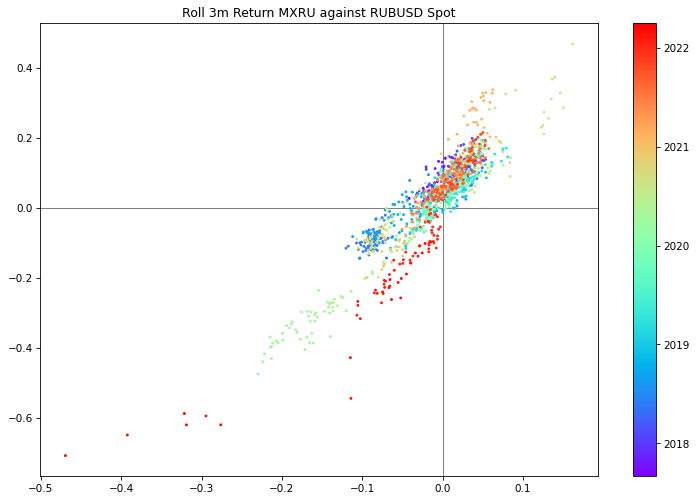

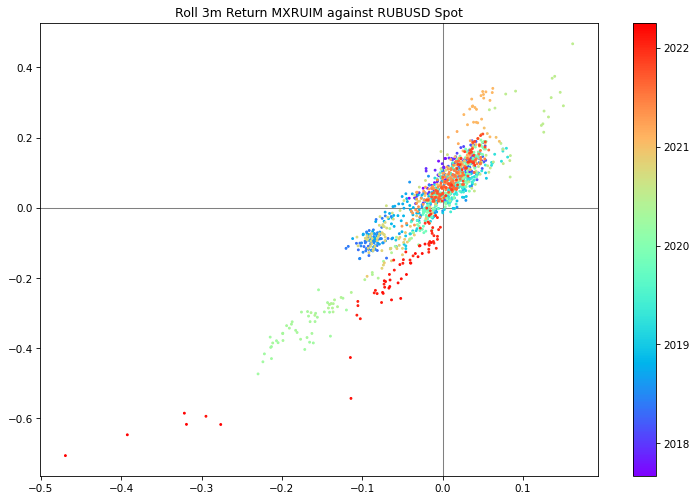

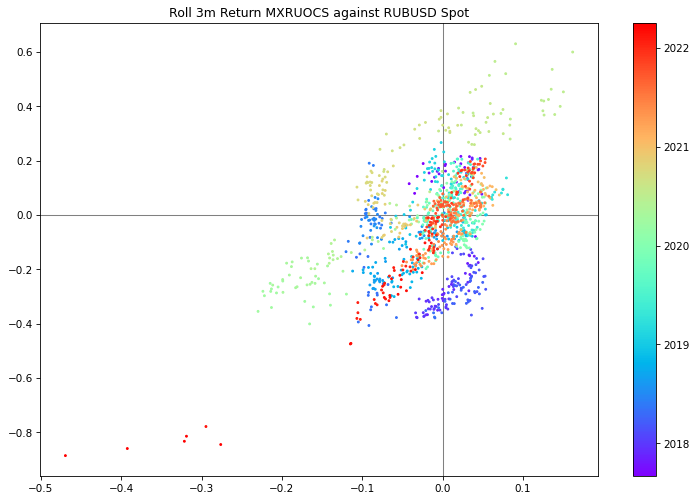

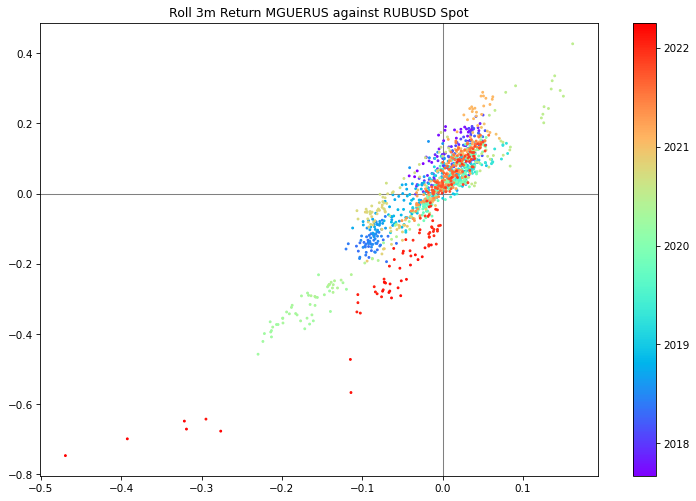

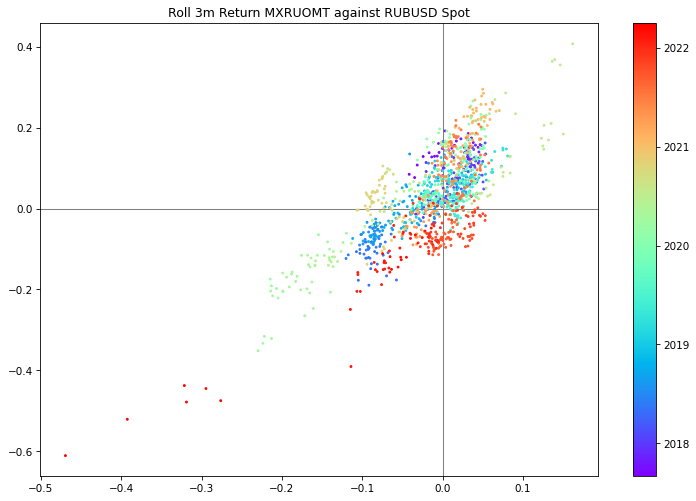

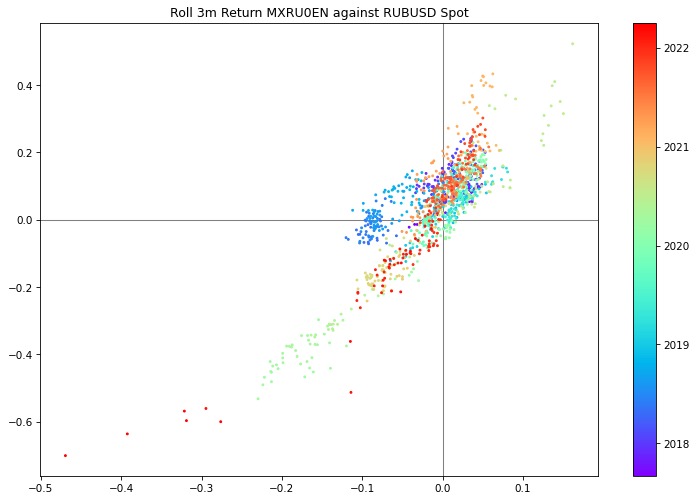

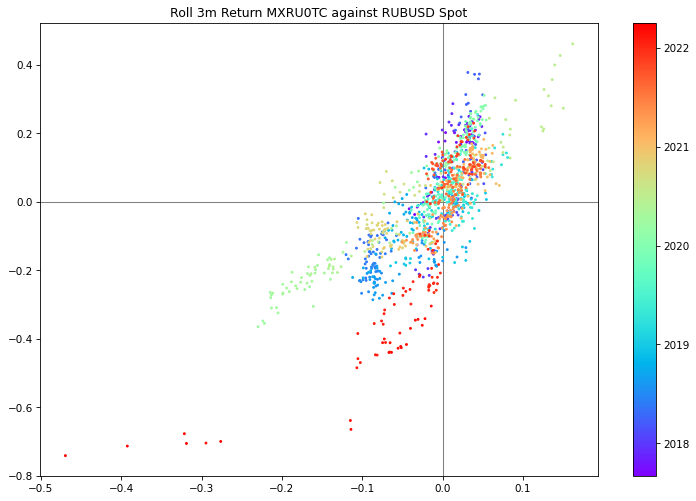

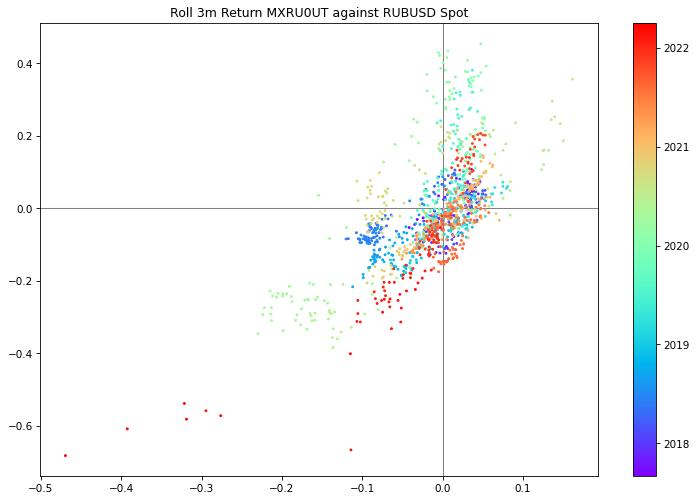

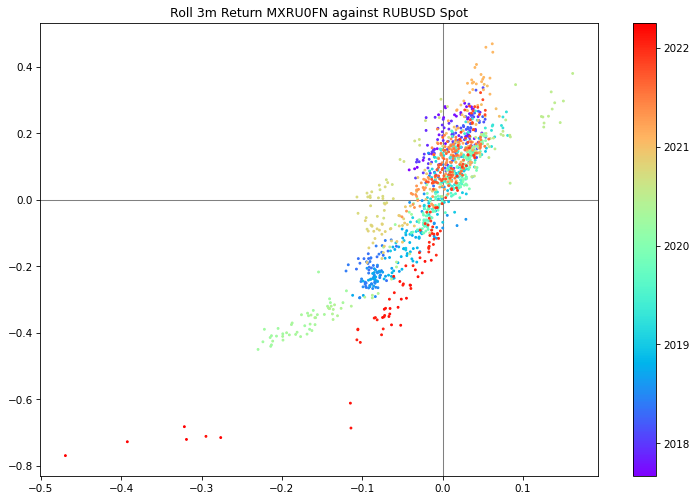

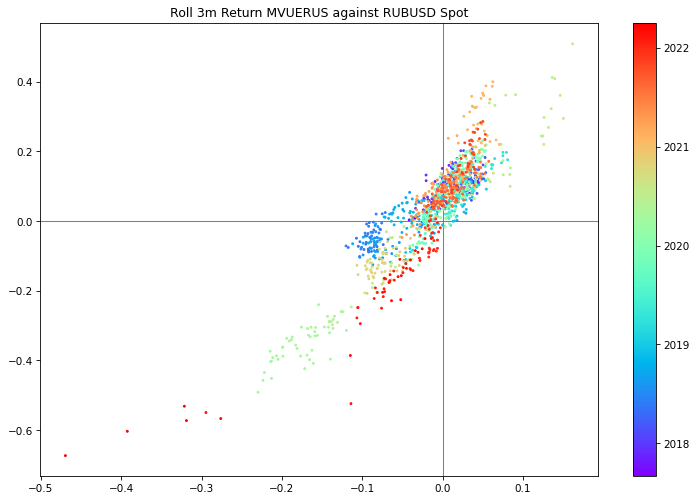

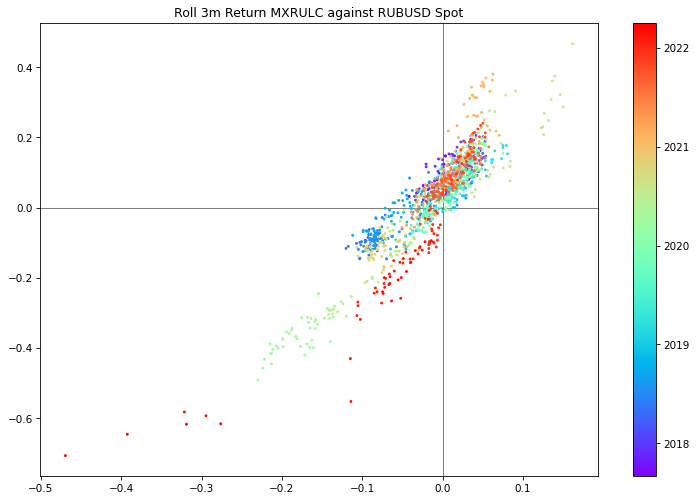

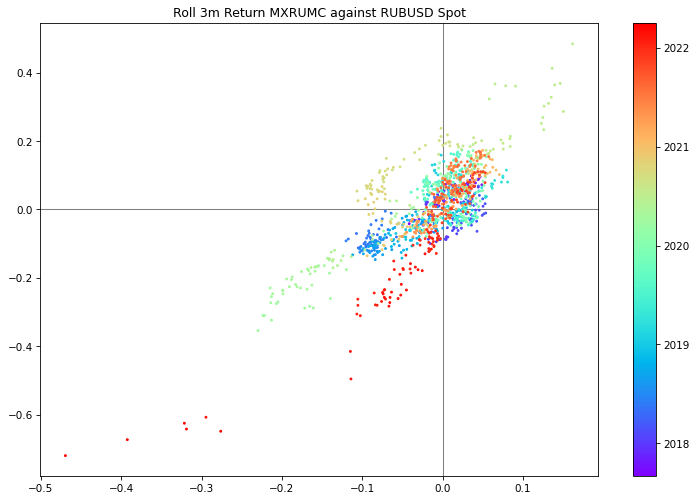

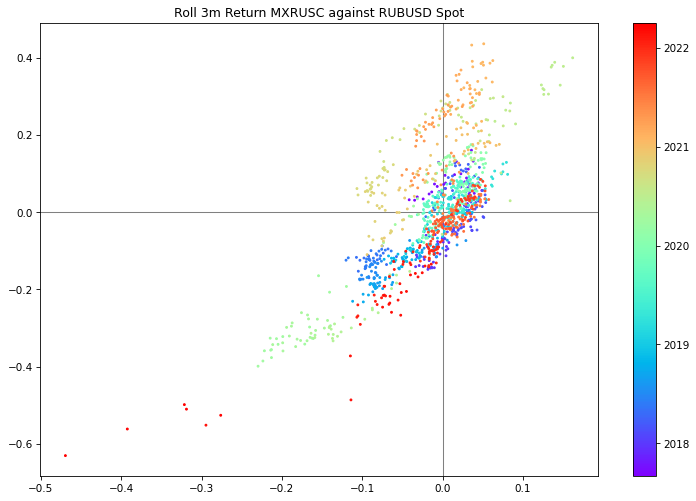

In [59]:
for col_name in RollRet_df.columns[:-1]:
  fig = plt.figure(figsize=(12,8), dpi=75)
  plt.title('Roll 3m Return {0} against {1}'.format(col_name,'RUBUSD Spot'))
  plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
  plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
  sc = plt.scatter(x=RollRet_df['RUBUSD Spot'], y=RollRet_df[col_name], s=3, c=[d.year + d.month/12 for d in RollRet_df.index], cmap='rainbow')
  cb = plt.colorbar(sc)

#2) Time varing beta estimate for stock indices (against RUBUSD)

To match the length of the dataset "RollRet_df", I take the size of traing window of Kalman filter as 62.

In [42]:
training_size = Ret_df.shape[0] - RollRet_df.shape[0]
print(training_size)

62


In [43]:
Ret_df_train = Ret_df.iloc[:training_size] 
Ret_df_test = Ret_df.iloc[training_size:]

In [49]:
Ret_df_train.columns

Index(['MXRU', 'MXRUIM', 'MXRUOCS', 'MGUERUS', 'MXRUOMT', 'MXRU0EN', 'MXRU0TC',
       'MXRU0UT', 'MXRU0FN', 'MVUERUS', 'MXRULC', 'MXRUMC', 'MXRUSC',
       'RUBUSD Spot'],
      dtype='object')

Estimate the time varying beta for the overall index first.

In [50]:
Y = 'MXRUIM'
X = 'RUBUSD Spot'
beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(Ret_df_train[X], Ret_df_train[Y])
resid_tr = Ret_df_train[Y] - beta_tr * Ret_df_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)  # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols) 

In the training set the OLS estimators of
alpha_tr =  0.0006430161630361364
beta_tr =  0.44057478049782084
var_eps =  7.759204810665933e-05


In [51]:
x = np.array([[alpha_tr],[beta_tr]])  # initial mean of alpha and beta
P = 0.1 * np.eye(2) # initial covariance of alpha and beta
eta_alpha = 0.0000001 # variance of the alpha process 
eta_beta = 0.01 # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])  # process covariance matrix 
R = np.array([[var_eps_ols]]) # variance for the measurement - 1 dim 
F = np.eye(2) # transition matrix
H = np.vstack( (np.ones(len(Ret_df_test)), Ret_df_test[X].values) ).T # measurement matrix

In [55]:
alphas, betas = np.full( len(Ret_df_test), np.NaN ), np.full( len(Ret_df_test), np.NaN )
for i,y in enumerate(Ret_df_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q
    
    #update
    S = (H[None,i] @ P @ H[None,i].T) + R   # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)             
    r = y - H[None,i]@x               # residuals
    x = x + K @ r                 # v is a scalar. 
    P = P - K @ H[None,i] @ P           # K @ H[None,i] is an outer product
    
    alphas[i] = x[0]; betas[i] = x[1]

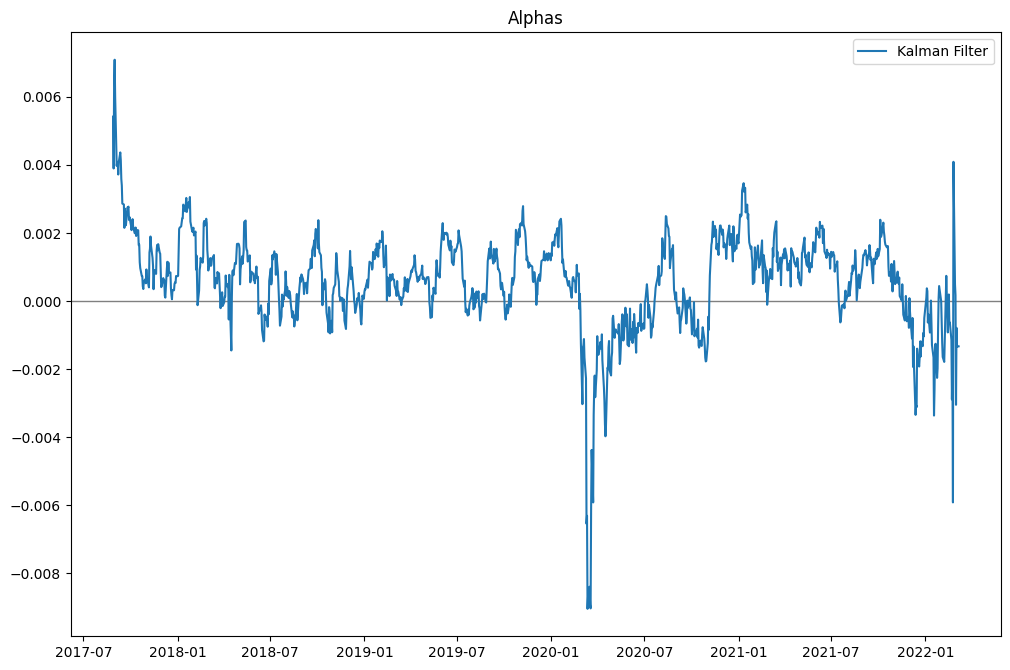

In [62]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot( Ret_df_test.index, alphas, label="Kalman Filter")
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.legend();
plt.title("Alphas");
plt.show()

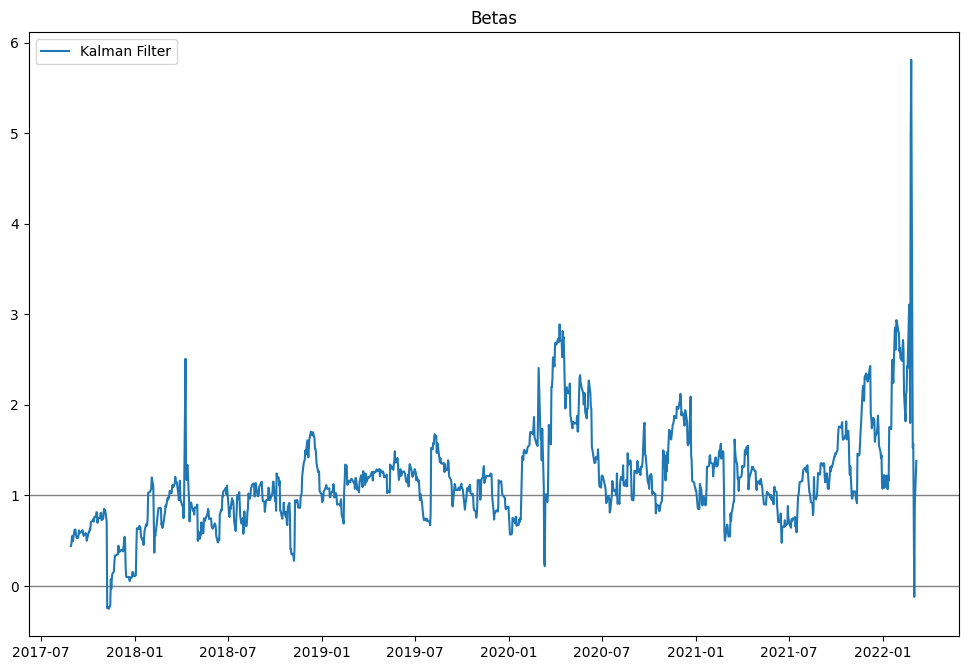

In [65]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot( Ret_df_test.index, betas, label="Kalman Filter")
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axhline(y=1,c="grey",linewidth=1.0,zorder=0)
plt.legend();
plt.title("Betas");
plt.show()